### Markov decision process

This week's methods are all built to solve __M__arkov __D__ecision __P__rocesses. In the broadest sense, an MDP is defined by how it changes states and how rewards are computed.

State transition is defined by $P(s' |s,a)$ - how likely are you to end at state $s'$ if you take action $a$ from state $s$. Now there's more than one way to define rewards, but we'll use $r(s,a,s')$ function for convenience.

_This notebook is inspired by the awesome_ [CS294](https://github.com/berkeleydeeprlcourse/homework/blob/36a0b58261acde756abd55306fbe63df226bf62b/hw2/HW2.ipynb) _by Berkeley_

For starters, let's define a simple MDP from this picture:

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Markov_Decision_Process.svg" width="400px" alt="Diagram by Waldoalvarez via Wikimedia Commons, CC BY-SA 4.0"/>

In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week2_model_based/submit.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week2_model_based/mdp.py

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [ ]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

We can now use MDP just as any other gym environment:

In [ ]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


but it also has other methods that you'll need for Value Iteration

In [ ]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Optional: Visualizing MDPs

You can also visualize any MDP with the drawing fuction donated by [neer201](https://github.com/neer201).

You have to install graphviz for system and for python. 

1. * For ubuntu just run: `sudo apt-get install graphviz` 
   * For OSX: `brew install graphviz`
2. `pip install graphviz`
3. restart the notebook

__Note:__ Installing graphviz on some OS (esp. Windows) may be tricky. However, you can ignore this part alltogether and use the standart vizualization.

In [ ]:
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

Graphviz available: True


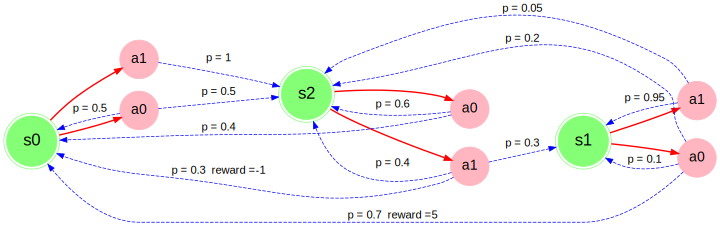

In [ ]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    display(plot_graph(mdp))

### Value Iteration

Now let's build something to solve this MDP. The simplest algorithm so far is __V__alue __I__teration

Here's the pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

First, let's write a function to compute the state-action value function $Q^{\pi}$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [ ]:
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """

    # <YOUR CODE>
    Q = 0
    all_states = mdp.get_all_states()

    for s_prime in all_states:
      # print(s_prime)
      # print(Q)

      # next_state = mdp.get_next_states(state, action)
      P = mdp.get_transition_prob(state, action, s_prime)
      r = mdp.get_reward(state, action, s_prime)
      Q += P * ( r + gamma*state_values[s_prime])

    return Q

In [ ]:
import numpy as np
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [ ]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as in formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state):
        return 0

    # <YOUR CODE>
    j = 0
    next_value = []
    all_actions = mdp.get_possible_actions(state)

    for action in all_actions:
      next_value.append( get_action_value(mdp, state_values, state, action, gamma) )
      # j+=1
    # print(max(next_value))
    return max(next_value)

In [ ]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 1.08)
assert np.isclose(get_new_state_value(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9), -13500000000.0), \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert test_Vs == test_Vs_copy, "Please do not change state_values in get_new_state_value"

1.8
1.08
-13500000000.0


Finally, let's combine everything we wrote into a working value iteration algo.

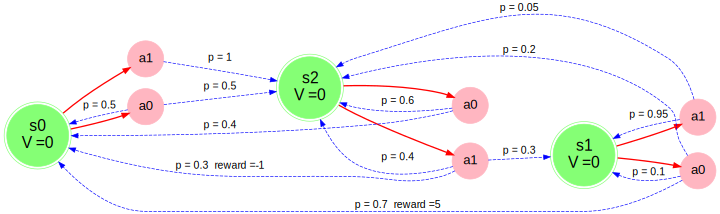

0.0
3.5
0.0
iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
0.0
3.815
0.645
iter    1   |   diff: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
0.5805
3.95945
0.9622499999999998
iter    2   |   diff: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
0.8660249999999998
4.3952705
1.2721965
iter    3   |   diff: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
1.14497685
4.670165464999999
1.578540525
iter    4   |   diff: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
1.4206864725
4.92578760185
1.8383630140499996
iter    5   |   diff: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
1.6545267126449996
5.1692587043705
2.0753586851324997
iter    6   |   diff: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
1.8678228166192496
5.3811496756835435
2.2895511892418847
iter    7   |   diff: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
2.0605960703176964
5.573151059345186
2.481461

In [ ]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
# stop VI if new values are this close to old values (or closer)
min_difference = 0.001

# initialize V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):

    # Compute new state values using the functions you defined above.
    # It must be a dict {state : float V_new(state)}
    # new_state_values = <YOUR CODE>
    all_states = mdp.get_all_states()
    new_state_values = {s: get_new_state_value(mdp, state_values, s, gamma) for s in all_states}

    assert isinstance(new_state_values, dict)

    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Terminated")
        break

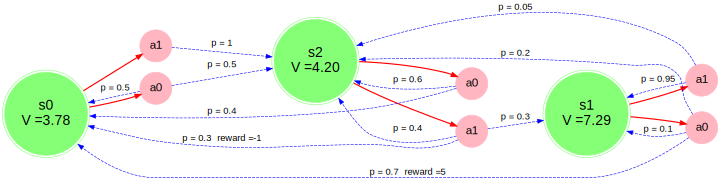

In [ ]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

In [ ]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01

Final state values: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


Now let's use those $V^{*}(s)$ to find optimal actions in each state

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
The only difference vs V(s) is that here we take not max but argmax: find action such with maximum Q(s,a).

In [ ]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None

    # <YOUR CODE>
    # get all the possible actions
    all_actions = mdp.get_possible_actions(state)
    # define Q similar as before but store in a table 
    Q_table = {action: get_action_value(mdp, state_values, state, action, gamma) for action in all_actions}
    
    # find max actions
    max_Q = max( Q_table.values() )
    max_actions = [action for action, q in Q_table.items() if q==max_Q]

    return max(max_actions)

In [ ]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a1'

assert get_optimal_action(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9) == 'a0', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert get_optimal_action(mdp, {'s0': -2e10, 's1': 0, 's2': -1e10}, 's0', 0.9) == 'a1', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"

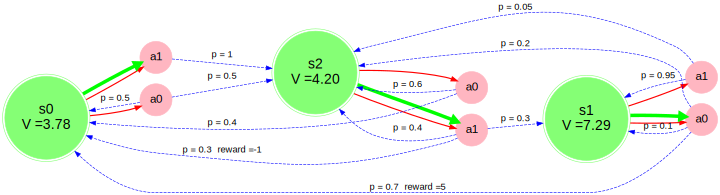

In [ ]:
if has_graphviz:
    display(plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value))

In [ ]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("average reward: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

average reward:  0.4643


### Frozen lake

In [ ]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [ ]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        # new_state_values = <YOUR CODE>
        all_states = mdp.get_all_states()
        new_state_values = {s: get_new_state_value(mdp, state_values, s, gamma=0.9) for s in all_states}

        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in mdp.get_all_states())

        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f " %
              (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [ ]:
state_values = value_iteration(mdp)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
iter    0   |   diff: 1.00000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9
0.9
1.0
iter    1   |   diff: 0.90000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.81
0.9
0.9
1.0
iter    2   |   diff: 0.81000   |   V(start): 0.000 
0.0
0.0
0.7290000000000001
0.0
0.0
0.81
0.7290000000000001
0.81
0.9
0.9
1.0
iter    3   |   diff: 0.72900   |   V(start): 0.000 
0.0
0.6561000000000001
0.7290000000000001
0.6561000000000001
0.6561000000000001
0.81
0.7290000000000001
0.81
0.9
0.9
1.0
iter    4   |   diff: 0.65610   |   V(start): 0.000 
0.5904900000000002
0.6561000000000001
0.7290000000000001
0.6561000000000001
0.6561000000000001
0.81
0.7290000000000001
0.81
0.9
0.9
1.0
iter    5   |   diff: 0.59049   |   V(start): 0.590 
0.5904900000000002
0.6561000000000001
0.7290000000000001
0.6561000000000001
0.6561000000000001
0.81
0.7290000000000001
0.81
0.9
0.9
1.0
iter    6   |   diff: 0.00000   |   V(start): 0.590 


In [ ]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

right

S*FF
FHFH
FFFH
HFFG

right

SF*F
FHFH
FFFH
HFFG

down

SFFF
FH*H
FFFH
HFFG

down

SFFF
FHFH
FF*H
HFFG

down

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*



### Let's visualize!

It's usually interesting to see what your algorithm actually learned under the hood. To do so, we'll plot state value functions and optimal actions at each VI step.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

after iteration 0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
iter    0   |   diff: 1.00000   |   V(start): 0.000 


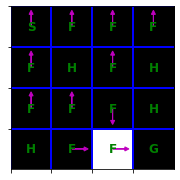

after iteration 1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9
0.9
1.0
iter    0   |   diff: 0.90000   |   V(start): 0.000 


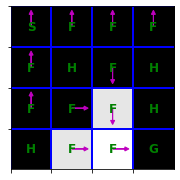

after iteration 2
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.81
0.9
0.9
1.0
iter    0   |   diff: 0.81000   |   V(start): 0.000 


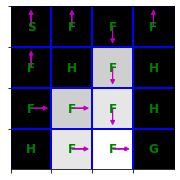

after iteration 3
0.0
0.0
0.7290000000000001
0.0
0.0
0.81
0.7290000000000001
0.81
0.9
0.9
1.0
iter    0   |   diff: 0.72900   |   V(start): 0.000 


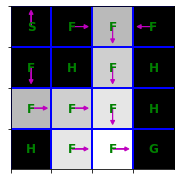

after iteration 4
0.0
0.6561000000000001
0.7290000000000001
0.6561000000000001
0.6561000000000001
0.81
0.7290000000000001
0.81
0.9
0.9
1.0
iter    0   |   diff: 0.65610   |   V(start): 0.000 


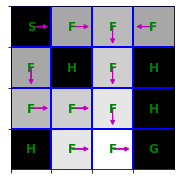

after iteration 5
0.5904900000000002
0.6561000000000001
0.7290000000000001
0.6561000000000001
0.6561000000000001
0.81
0.7290000000000001
0.81
0.9
0.9
1.0
iter    0   |   diff: 0.59049   |   V(start): 0.590 


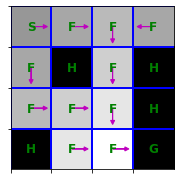

after iteration 6
0.5904900000000002
0.6561000000000001
0.7290000000000001
0.6561000000000001
0.6561000000000001
0.81
0.7290000000000001
0.81
0.9
0.9
1.0
iter    0   |   diff: 0.00000   |   V(start): 0.590 


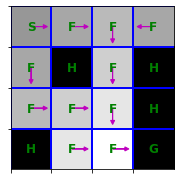

after iteration 7
0.5904900000000002
0.6561000000000001
0.7290000000000001
0.6561000000000001
0.6561000000000001
0.81
0.7290000000000001
0.81
0.9
0.9
1.0
iter    0   |   diff: 0.00000   |   V(start): 0.590 


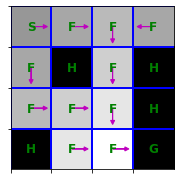

after iteration 8
0.5904900000000002
0.6561000000000001
0.7290000000000001
0.6561000000000001
0.6561000000000001
0.81
0.7290000000000001
0.81
0.9
0.9
1.0
iter    0   |   diff: 0.00000   |   V(start): 0.590 


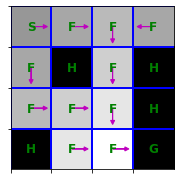

after iteration 9
0.5904900000000002
0.6561000000000001
0.7290000000000001
0.6561000000000001
0.6561000000000001
0.81
0.7290000000000001
0.81
0.9
0.9
1.0
iter    0   |   diff: 0.00000   |   V(start): 0.590 


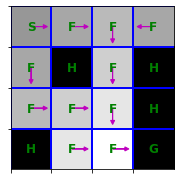

In [ ]:
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 29
0.19816843356161376
0.22234453053304482
0.2493938602121421
0.2796305131378171
0.3133722252823468
0.35019005942691844
0.39118770221758736
0.43410192748245185
0.20337356473110288
0.22955578700659218
0.25934276277310475
0.29368086707410623
0.34703394392239617
0.39043262590567296
0.439376003543815
0.49007888169577374
0.18924042122324838
0.2107255730552412
0.22752308948428376
0.3707059345648659
0.4173224538683299
0.4935222045991991
0.5533992739082584
0.2089090399242522
0.23700150977169715
0.26918572784453
0.30704795132426943
0.3790715448565584
0.55535768747389
0.6250466757738937
0.18715573999139043
0.2106315716600394
0.22751885941080063
0.450931342040345
0.5090116789824761
0.5969195753641
0.7060845425036558
0.1587393711331045
0.4036170854101869
0.47941472327671886
0.5668182875126182
0.7993201940736274
0.15312108737753177
0.28608236750835037
0.33980354571338706
0.6731415123027102
0.9424083769633508
0.18053165447429703
0.20434232334387803
0.24092212214673983
0.7048602223065

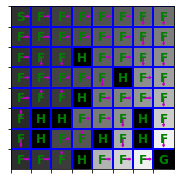

In [ ]:
from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

Massive tests

In [ ]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Well done!")

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
iter    0   |   diff: 1.00000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9
0.9
1.0
iter    1   |   diff: 0.90000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.81
0.0
0.81
0.9
0.9
1.0
iter    2   |   diff: 0.81000   |   V(start): 0.000 
0.0
0.0
0.7290000000000001
0.0
0.0
0.81
0.7290000000000001
0.81
0.9
0.9
1.0
iter    3   |   diff: 0.72900   |   V(start): 0.000 
0.0
0.6561000000000001
0.7290000000000001
0.6561000000000001
0.6561000000000001
0.81
0.7290000000000001
0.81
0.9
0.9
1.0
iter    4   |   diff: 0.65610   |   V(start): 0.000 
0.5904900000000002
0.6561000000000001
0.7290000000000001
0.6561000000000001
0.6561000000000001
0.81
0.7290000000000001
0.81
0.9
0.9
1.0
iter    5   |   diff: 0.59049   |   V(start): 0.590 
0.5904900000000002
0.6561000000000001
0.7290000000000001
0.6561000000000001
0.6561000000000001
0.81
0.7290000000000001
0.81
0.9
0.9
1.0
iter    6   |   diff: 0.00000   |   V(start): 0.590 
average reward:  1.0
Well 

In [ ]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9
iter    0   |   diff: 0.90000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7290000000000001
0.7290000000000001
0.9405
iter    1   |   diff: 0.72900   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.5904900000000002
0.0
0.6232950000000002
0.7618050000000001
0.79461
0.9751275
iter    2   |   diff: 0.62330   |   V(start): 0.000 
0.0
0.0
0.47829690000000014
0.0
0.0
0.6170620500000001
0.5048689500000001
0.6779153250000001
0.81790155
0.8536590000000001
0.9781619625
iter    3   |   diff: 0.50487   |   V(start): 0.000 
0.0
0.38742048900000015
0.4998202605000001
0.38742048900000015
0.4089438495000001
0.6625002555
0.54911141325
0.7509884625000001
0.82281737925
0.8612320342500001
0.9808228580625
iter    4   |   diff: 0.40894   |   V(start): 0.000 
0.3486784401000001
0.42228833301000007
0.571493050965
0.42228833301000007
0.46318271796000005
0.6664820771925001
0.6267031278525002
0.7593347434050001
0.8282609958431251
0.8670164373843751
0.98116381067

In [ ]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Well done!")

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.75
iter    0   |   diff: 0.75000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5062500000000001
0.5062500000000001
0.834375
iter    1   |   diff: 0.50625   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.34171875000000007
0.0
0.39867187500000006
0.563203125
0.6201562500000001
0.9008203125
iter    2   |   diff: 0.39867   |   V(start): 0.000 
0.0
0.0
0.23066015625000003
0.0
0.0
0.380162109375
0.269103515625
0.4819658203125
0.6529042968750001
0.7226718750000001
0.9147026367187501
iter    3   |   diff: 0.26910   |   V(start): 0.000 
0.0
0.15569560546875003
0.256609423828125
0.15569560546875003
0.18164487304687502
0.44071040039062503
0.3253269287109375
0.5915293945312501
0.6716454345703126
0.7529460205078127
0.926355780029297
iter    4   |   diff: 0.18164   |   V(start): 0.000 
0.14012604492187503
0.19072711669921877
0.3325110314941407
0.19072711669921877
0.24003072509765627
0.45336066833496097
0.4197173895263673
0.6203979547119142
0.691837208

In [ ]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.8
0.0
0.0
0.0
0.0
0.0
0.8
iter    0   |   diff: 0.80000   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5760000000000001
0.0
0.0
0.0
0.0
0.8720000000000001
0.0
0.0
0.0
0.0
0.5760000000000001
0.8720000000000001
iter    1   |   diff: 0.57600   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4147200000000001
0.0
0.0
0.0
0.0
0.6796800000000002
0.0
0.0
0.0
0.4147200000000001
0.87848
0.0
0.0
0.0
0.4147200000000001
0.6796800000000002
0.87848
iter    2   |   diff: 0.41472   |   V(start): 0.000 
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

### Submit to coursera

If your submission doesn't finish in 30 seconds, set `verbose=True` and try again.

In [ ]:
from submit import submit_assigment
submit_assigment(
    get_action_value,
    get_new_state_value,
    get_optimal_action,
    value_iteration,
    'email',
    'token',
    verbose=False,
)

Submitted to Coursera platform. See results on assignment page!
